In [1]:
import datetime
from IPython.display import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
# MNIST 데이터를 불러옵니다.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

/home/crypto736/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

In [3]:
# 생성된 MNIST 이미지를 8x8 Grid로 보여주는 plot 함수를 정의합니다.
def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        plt.imshow(sample.reshape(28, 28))
    return fig

In [4]:
# 설정값들을 선언합니다.
num_epoch = 100000
batch_size = 64
num_input = 28 * 28
num_latent_variable = 100
num_hidden = 128
learning_rate = 0.001

In [5]:
# 플레이스 홀더를 선언합니다.
X = tf.placeholder(tf.float32, [None, num_input])               # 인풋 이미지
z = tf.placeholder(tf.float32, [None, num_latent_variable])     # 인풋 Latent Variable

In [6]:
# Generator 변수들 설정 
# 100 -> 128 -> 784
with tf.variable_scope('generator'):
    # 히든 레이어 파라미터 
    G_W1 = tf.Variable(tf.random_normal(shape=[num_latent_variable, num_hidden], stddev=5e-2))   
    G_b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    # 아웃풋 레이어 파라미터
    G_W2 = tf.Variable(tf.random_normal(shape=[num_hidden, num_input], stddev=5e-2))   
    G_b2 = tf.Variable(tf.constant(0.1, shape=[num_input]))

In [7]:
# Discriminator 변수들 설정 
# 784 -> 128 -> 1
with tf.variable_scope('discriminator'):
    # 히든 레이어 파라미터
    D_W1 = tf.Variable(tf.random_normal(shape=[num_input, num_hidden], stddev=5e-2))   
    D_b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    # 아웃풋 레이어 파라미터
    D_W2 = tf.Variable(tf.random_normal(shape=[num_hidden, 1], stddev=5e-2))   
    D_b2 = tf.Variable(tf.constant(0.1, shape=[1]))

In [8]:
# Generator를 생성하는 함수를 정의합니다.
# Inputs:
#   X : 인풋 Latent Variable
# Output:
#   generated_mnist_image : 생성된 MNIST 이미지
def build_generator(X):
    hidden_layer = tf.nn.relu((tf.matmul(X, G_W1) + G_b1))
    output_layer = tf.matmul(hidden_layer, G_W2) + G_b2
    generated_mnist_image = tf.nn.sigmoid(output_layer)

    return generated_mnist_image

In [9]:
# Discriminator를 생성하는 함수를 정의합니다.
# Inputs:
#   X : 인풋 이미지
# Output:
#   predicted_value : Discriminator가 판단한 True(1) or Fake(0)
#   logits : sigmoid를 씌우기전의 출력값
def build_discriminator(X):
    hidden_layer = tf.nn.relu((tf.matmul(X, D_W1) + D_b1))
    logits = tf.matmul(hidden_layer, D_W2) + D_b2
    predicted_value = tf.nn.sigmoid(logits)

    return predicted_value, logits

In [10]:
# 생성자(Generator)를 선언합니다.
G = build_generator(z)

In [11]:
# 구분자(Discriminator)를 선언합니다.
D_real, D_real_logits = build_discriminator(X)  # D(x)
D_fake, D_fake_logits = build_discriminator(G)  # D(G(z))

In [12]:
# Discriminator의 손실 함수를 정의합니다.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))    # log(D(x))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))   # log(1-D(G(z)))
d_loss = d_loss_real + d_loss_fake  # log(D(x)) + log(1-D(G(z)))

In [13]:
# Generator의 손실 함수를 정의합니다.
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))         # log(D(G(z))

In [14]:
# 전체 파라미터를 Discriminator와 관련된 파라미터와 Generator와 관련된 파라미터로 나눕니다.
tvar = tf.trainable_variables()
dvar = [var for var in tvar if 'discriminator' in var.name]
gvar = [var for var in tvar if 'generator' in var.name]

In [15]:
# Discriminator와 Generator의 Optimizer를 정의합니다.
d_train_step = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=dvar)
g_train_step = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=gvar)

In [16]:
# 생성된 이미지들을 저장할 generated_outputs 폴더를 생성합니다.
num_img = 0
if not os.path.exists('generated_output/'):
    os.makedirs('generated_output/')

In [17]:
start_time = datetime.datetime.now()

In [18]:
with tf.Session() as sess:
    # 변수들에 초기값을 할당합니다.
    sess.run(tf.global_variables_initializer())

    # num_epoch 횟수만큼 최적화를 수행합니다.
    for i in range(num_epoch):
        # MNIST 이미지를 batch_size만큼 불러옵니다. 
        batch_X, _ = mnist.train.next_batch(batch_size)
        # Latent Variable의 인풋으로 사용할 noise를 Uniform Distribution에서 batch_size만큼 샘플링합니다.
        batch_noise = np.random.uniform(-1., 1., [batch_size, 100])

        # 500번 반복할때마다 생성된 이미지를 저장합니다.
        if i % 500 == 0:
            samples = sess.run(G, feed_dict={z: np.random.uniform(-1., 1., [64, 100])})
            fig = plot(samples)
            plt.savefig('generated_output/%s.png' % str(num_img).zfill(3), bbox_inches='tight')
            num_img += 1
            plt.close(fig)

        # Discriminator 최적화를 수행하고 Discriminator의 손실함수를 return합니다.
        _, d_loss_print = sess.run([d_train_step, d_loss], feed_dict={X: batch_X, z: batch_noise})

        # Generator 최적화를 수행하고 Generator 손실함수를 return합니다.
        _, g_loss_print = sess.run([g_train_step, g_loss], feed_dict={z: batch_noise})

        # 100번 반복할때마다 Discriminator의 손실함수와 Generator 손실함수를 출력합니다.
        if i % 100 == 0:
            print('반복(Epoch): %d, Generator 손실함수(g_loss): %f, Discriminator 손실함수(d_loss): %f' % (i, g_loss_print, d_loss_print))
            
end_time= datetime.datetime.now()
learning_time = end_time - start_time
print('훈련시간: %d 마이크로초' % learning_time.microseconds)
print('훈련시간: %d 초' % learning_time.seconds)

반복(Epoch): 0, Generator 손실함수(g_loss): 0.885471, Discriminator 손실함수(d_loss): 1.672786
반복(Epoch): 100, Generator 손실함수(g_loss): 2.433144, Discriminator 손실함수(d_loss): 0.519332
반복(Epoch): 200, Generator 손실함수(g_loss): 3.969491, Discriminator 손실함수(d_loss): 0.090409
반복(Epoch): 300, Generator 손실함수(g_loss): 4.632869, Discriminator 손실함수(d_loss): 0.042643
반복(Epoch): 400, Generator 손실함수(g_loss): 5.230685, Discriminator 손실함수(d_loss): 0.050043
반복(Epoch): 500, Generator 손실함수(g_loss): 5.615204, Discriminator 손실함수(d_loss): 0.028475
반복(Epoch): 600, Generator 손실함수(g_loss): 6.745543, Discriminator 손실함수(d_loss): 0.012471
반복(Epoch): 700, Generator 손실함수(g_loss): 8.492043, Discriminator 손실함수(d_loss): 0.018313
반복(Epoch): 800, Generator 손실함수(g_loss): 6.987991, Discriminator 손실함수(d_loss): 0.043576
반복(Epoch): 900, Generator 손실함수(g_loss): 9.116617, Discriminator 손실함수(d_loss): 0.032210
반복(Epoch): 1000, Generator 손실함수(g_loss): 19.281754, Discriminator 손실함수(d_loss): 0.016166
반복(Epoch): 1100, Generator 손실함수(g_loss): 13

반복(Epoch): 9400, Generator 손실함수(g_loss): 2.549687, Discriminator 손실함수(d_loss): 0.400596
반복(Epoch): 9500, Generator 손실함수(g_loss): 2.678483, Discriminator 손실함수(d_loss): 0.642717
반복(Epoch): 9600, Generator 손실함수(g_loss): 2.555380, Discriminator 손실함수(d_loss): 0.581086
반복(Epoch): 9700, Generator 손실함수(g_loss): 3.017417, Discriminator 손실함수(d_loss): 0.717299
반복(Epoch): 9800, Generator 손실함수(g_loss): 2.300947, Discriminator 손실함수(d_loss): 0.710191
반복(Epoch): 9900, Generator 손실함수(g_loss): 2.223754, Discriminator 손실함수(d_loss): 0.680167
반복(Epoch): 10000, Generator 손실함수(g_loss): 2.132863, Discriminator 손실함수(d_loss): 0.602326
반복(Epoch): 10100, Generator 손실함수(g_loss): 2.660165, Discriminator 손실함수(d_loss): 0.577823
반복(Epoch): 10200, Generator 손실함수(g_loss): 2.100833, Discriminator 손실함수(d_loss): 0.635121
반복(Epoch): 10300, Generator 손실함수(g_loss): 2.256523, Discriminator 손실함수(d_loss): 0.589799
반복(Epoch): 10400, Generator 손실함수(g_loss): 2.515713, Discriminator 손실함수(d_loss): 0.662845
반복(Epoch): 10500, Generator

반복(Epoch): 18700, Generator 손실함수(g_loss): 1.960170, Discriminator 손실함수(d_loss): 0.788750
반복(Epoch): 18800, Generator 손실함수(g_loss): 2.030211, Discriminator 손실함수(d_loss): 0.651539
반복(Epoch): 18900, Generator 손실함수(g_loss): 2.361357, Discriminator 손실함수(d_loss): 0.675175
반복(Epoch): 19000, Generator 손실함수(g_loss): 2.182210, Discriminator 손실함수(d_loss): 0.742381
반복(Epoch): 19100, Generator 손실함수(g_loss): 2.336514, Discriminator 손실함수(d_loss): 0.659112
반복(Epoch): 19200, Generator 손실함수(g_loss): 1.834744, Discriminator 손실함수(d_loss): 0.765123
반복(Epoch): 19300, Generator 손실함수(g_loss): 1.787568, Discriminator 손실함수(d_loss): 0.722501
반복(Epoch): 19400, Generator 손실함수(g_loss): 2.136549, Discriminator 손실함수(d_loss): 0.620150
반복(Epoch): 19500, Generator 손실함수(g_loss): 1.703320, Discriminator 손실함수(d_loss): 0.964013
반복(Epoch): 19600, Generator 손실함수(g_loss): 1.949565, Discriminator 손실함수(d_loss): 0.872420
반복(Epoch): 19700, Generator 손실함수(g_loss): 1.526150, Discriminator 손실함수(d_loss): 0.926490
반복(Epoch): 19800, Gen

반복(Epoch): 28000, Generator 손실함수(g_loss): 1.703577, Discriminator 손실함수(d_loss): 0.785320
반복(Epoch): 28100, Generator 손실함수(g_loss): 1.863742, Discriminator 손실함수(d_loss): 0.667871
반복(Epoch): 28200, Generator 손실함수(g_loss): 1.816119, Discriminator 손실함수(d_loss): 0.916734
반복(Epoch): 28300, Generator 손실함수(g_loss): 1.726333, Discriminator 손실함수(d_loss): 0.960382
반복(Epoch): 28400, Generator 손실함수(g_loss): 1.738102, Discriminator 손실함수(d_loss): 0.823155
반복(Epoch): 28500, Generator 손실함수(g_loss): 2.001662, Discriminator 손실함수(d_loss): 0.723967
반복(Epoch): 28600, Generator 손실함수(g_loss): 2.222333, Discriminator 손실함수(d_loss): 0.848989
반복(Epoch): 28700, Generator 손실함수(g_loss): 1.629091, Discriminator 손실함수(d_loss): 0.954683
반복(Epoch): 28800, Generator 손실함수(g_loss): 1.416022, Discriminator 손실함수(d_loss): 0.875278
반복(Epoch): 28900, Generator 손실함수(g_loss): 2.202364, Discriminator 손실함수(d_loss): 0.746044
반복(Epoch): 29000, Generator 손실함수(g_loss): 1.938945, Discriminator 손실함수(d_loss): 0.804780
반복(Epoch): 29100, Gen

반복(Epoch): 37300, Generator 손실함수(g_loss): 1.753809, Discriminator 손실함수(d_loss): 0.809118
반복(Epoch): 37400, Generator 손실함수(g_loss): 2.056427, Discriminator 손실함수(d_loss): 0.668897
반복(Epoch): 37500, Generator 손실함수(g_loss): 2.018787, Discriminator 손실함수(d_loss): 0.805693
반복(Epoch): 37600, Generator 손실함수(g_loss): 2.154636, Discriminator 손실함수(d_loss): 0.840850
반복(Epoch): 37700, Generator 손실함수(g_loss): 2.178332, Discriminator 손실함수(d_loss): 0.667765
반복(Epoch): 37800, Generator 손실함수(g_loss): 1.864969, Discriminator 손실함수(d_loss): 0.787730
반복(Epoch): 37900, Generator 손실함수(g_loss): 1.971312, Discriminator 손실함수(d_loss): 0.804843
반복(Epoch): 38000, Generator 손실함수(g_loss): 2.002361, Discriminator 손실함수(d_loss): 0.724083
반복(Epoch): 38100, Generator 손실함수(g_loss): 1.899163, Discriminator 손실함수(d_loss): 0.830949
반복(Epoch): 38200, Generator 손실함수(g_loss): 2.174805, Discriminator 손실함수(d_loss): 0.706845
반복(Epoch): 38300, Generator 손실함수(g_loss): 2.007004, Discriminator 손실함수(d_loss): 0.807914
반복(Epoch): 38400, Gen

반복(Epoch): 46600, Generator 손실함수(g_loss): 2.126139, Discriminator 손실함수(d_loss): 0.679228
반복(Epoch): 46700, Generator 손실함수(g_loss): 1.765878, Discriminator 손실함수(d_loss): 0.804564
반복(Epoch): 46800, Generator 손실함수(g_loss): 2.068581, Discriminator 손실함수(d_loss): 0.682760
반복(Epoch): 46900, Generator 손실함수(g_loss): 2.397768, Discriminator 손실함수(d_loss): 0.654857
반복(Epoch): 47000, Generator 손실함수(g_loss): 2.341138, Discriminator 손실함수(d_loss): 0.601343
반복(Epoch): 47100, Generator 손실함수(g_loss): 2.008313, Discriminator 손실함수(d_loss): 0.586916
반복(Epoch): 47200, Generator 손실함수(g_loss): 1.965916, Discriminator 손실함수(d_loss): 0.946931
반복(Epoch): 47300, Generator 손실함수(g_loss): 2.221422, Discriminator 손실함수(d_loss): 0.673799
반복(Epoch): 47400, Generator 손실함수(g_loss): 2.180872, Discriminator 손실함수(d_loss): 0.714422
반복(Epoch): 47500, Generator 손실함수(g_loss): 2.402260, Discriminator 손실함수(d_loss): 0.647999
반복(Epoch): 47600, Generator 손실함수(g_loss): 1.963494, Discriminator 손실함수(d_loss): 0.681185
반복(Epoch): 47700, Gen

반복(Epoch): 55900, Generator 손실함수(g_loss): 1.850925, Discriminator 손실함수(d_loss): 0.748720
반복(Epoch): 56000, Generator 손실함수(g_loss): 2.189030, Discriminator 손실함수(d_loss): 0.773368
반복(Epoch): 56100, Generator 손실함수(g_loss): 1.937507, Discriminator 손실함수(d_loss): 0.774326
반복(Epoch): 56200, Generator 손실함수(g_loss): 2.032316, Discriminator 손실함수(d_loss): 0.702789
반복(Epoch): 56300, Generator 손실함수(g_loss): 2.101541, Discriminator 손실함수(d_loss): 0.651625
반복(Epoch): 56400, Generator 손실함수(g_loss): 2.301017, Discriminator 손실함수(d_loss): 0.510742
반복(Epoch): 56500, Generator 손실함수(g_loss): 2.007604, Discriminator 손실함수(d_loss): 0.937537
반복(Epoch): 56600, Generator 손실함수(g_loss): 1.955413, Discriminator 손실함수(d_loss): 0.814062
반복(Epoch): 56700, Generator 손실함수(g_loss): 2.065773, Discriminator 손실함수(d_loss): 0.659857
반복(Epoch): 56800, Generator 손실함수(g_loss): 2.283050, Discriminator 손실함수(d_loss): 0.552322
반복(Epoch): 56900, Generator 손실함수(g_loss): 1.879371, Discriminator 손실함수(d_loss): 0.794150
반복(Epoch): 57000, Gen

반복(Epoch): 65200, Generator 손실함수(g_loss): 1.806383, Discriminator 손실함수(d_loss): 0.703842
반복(Epoch): 65300, Generator 손실함수(g_loss): 1.907911, Discriminator 손실함수(d_loss): 0.773866
반복(Epoch): 65400, Generator 손실함수(g_loss): 2.110310, Discriminator 손실함수(d_loss): 0.599231
반복(Epoch): 65500, Generator 손실함수(g_loss): 1.466079, Discriminator 손실함수(d_loss): 0.717786
반복(Epoch): 65600, Generator 손실함수(g_loss): 1.778525, Discriminator 손실함수(d_loss): 1.004056
반복(Epoch): 65700, Generator 손실함수(g_loss): 2.094175, Discriminator 손실함수(d_loss): 0.573305
반복(Epoch): 65800, Generator 손실함수(g_loss): 2.075578, Discriminator 손실함수(d_loss): 0.852545
반복(Epoch): 65900, Generator 손실함수(g_loss): 2.326792, Discriminator 손실함수(d_loss): 0.750226
반복(Epoch): 66000, Generator 손실함수(g_loss): 2.056242, Discriminator 손실함수(d_loss): 0.804766
반복(Epoch): 66100, Generator 손실함수(g_loss): 2.040508, Discriminator 손실함수(d_loss): 0.712354
반복(Epoch): 66200, Generator 손실함수(g_loss): 1.938512, Discriminator 손실함수(d_loss): 0.653465
반복(Epoch): 66300, Gen

반복(Epoch): 74500, Generator 손실함수(g_loss): 2.100939, Discriminator 손실함수(d_loss): 0.696488
반복(Epoch): 74600, Generator 손실함수(g_loss): 1.745935, Discriminator 손실함수(d_loss): 0.859477
반복(Epoch): 74700, Generator 손실함수(g_loss): 1.756744, Discriminator 손실함수(d_loss): 0.733661
반복(Epoch): 74800, Generator 손실함수(g_loss): 2.089292, Discriminator 손실함수(d_loss): 0.745817
반복(Epoch): 74900, Generator 손실함수(g_loss): 2.014771, Discriminator 손실함수(d_loss): 0.605860
반복(Epoch): 75000, Generator 손실함수(g_loss): 1.950103, Discriminator 손실함수(d_loss): 0.775948
반복(Epoch): 75100, Generator 손실함수(g_loss): 2.238317, Discriminator 손실함수(d_loss): 0.798072
반복(Epoch): 75200, Generator 손실함수(g_loss): 2.166540, Discriminator 손실함수(d_loss): 0.784449
반복(Epoch): 75300, Generator 손실함수(g_loss): 2.032292, Discriminator 손실함수(d_loss): 0.706006
반복(Epoch): 75400, Generator 손실함수(g_loss): 1.941855, Discriminator 손실함수(d_loss): 0.826900
반복(Epoch): 75500, Generator 손실함수(g_loss): 2.189982, Discriminator 손실함수(d_loss): 0.786858
반복(Epoch): 75600, Gen

반복(Epoch): 83800, Generator 손실함수(g_loss): 2.263891, Discriminator 손실함수(d_loss): 0.800714
반복(Epoch): 83900, Generator 손실함수(g_loss): 2.297237, Discriminator 손실함수(d_loss): 0.696900
반복(Epoch): 84000, Generator 손실함수(g_loss): 1.868319, Discriminator 손실함수(d_loss): 0.709123
반복(Epoch): 84100, Generator 손실함수(g_loss): 2.033155, Discriminator 손실함수(d_loss): 0.643035
반복(Epoch): 84200, Generator 손실함수(g_loss): 1.896006, Discriminator 손실함수(d_loss): 0.785551
반복(Epoch): 84300, Generator 손실함수(g_loss): 2.308982, Discriminator 손실함수(d_loss): 0.429663
반복(Epoch): 84400, Generator 손실함수(g_loss): 2.036349, Discriminator 손실함수(d_loss): 0.754578
반복(Epoch): 84500, Generator 손실함수(g_loss): 2.174817, Discriminator 손실함수(d_loss): 0.729509
반복(Epoch): 84600, Generator 손실함수(g_loss): 2.113969, Discriminator 손실함수(d_loss): 0.648641
반복(Epoch): 84700, Generator 손실함수(g_loss): 2.040937, Discriminator 손실함수(d_loss): 0.522387
반복(Epoch): 84800, Generator 손실함수(g_loss): 2.083652, Discriminator 손실함수(d_loss): 0.848363
반복(Epoch): 84900, Gen

반복(Epoch): 93100, Generator 손실함수(g_loss): 2.179640, Discriminator 손실함수(d_loss): 0.781426
반복(Epoch): 93200, Generator 손실함수(g_loss): 2.053477, Discriminator 손실함수(d_loss): 0.712141
반복(Epoch): 93300, Generator 손실함수(g_loss): 2.186187, Discriminator 손실함수(d_loss): 0.923825
반복(Epoch): 93400, Generator 손실함수(g_loss): 2.071864, Discriminator 손실함수(d_loss): 0.657565
반복(Epoch): 93500, Generator 손실함수(g_loss): 2.089487, Discriminator 손실함수(d_loss): 0.534874
반복(Epoch): 93600, Generator 손실함수(g_loss): 2.046156, Discriminator 손실함수(d_loss): 0.769733
반복(Epoch): 93700, Generator 손실함수(g_loss): 2.660202, Discriminator 손실함수(d_loss): 0.602289
반복(Epoch): 93800, Generator 손실함수(g_loss): 2.168975, Discriminator 손실함수(d_loss): 0.604375
반복(Epoch): 93900, Generator 손실함수(g_loss): 2.479575, Discriminator 손실함수(d_loss): 0.692952
반복(Epoch): 94000, Generator 손실함수(g_loss): 2.548140, Discriminator 손실함수(d_loss): 0.700487
반복(Epoch): 94100, Generator 손실함수(g_loss): 2.394606, Discriminator 손실함수(d_loss): 0.570763
반복(Epoch): 94200, Gen

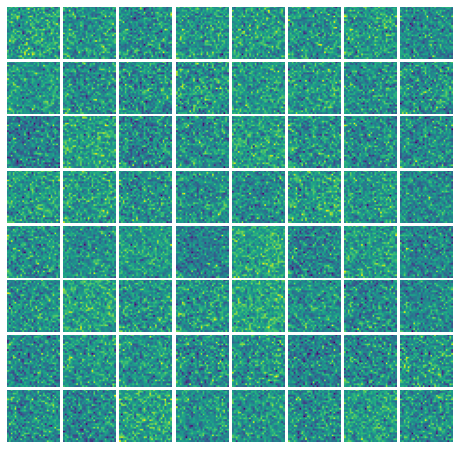

In [19]:
Image('generated_output/000.png')

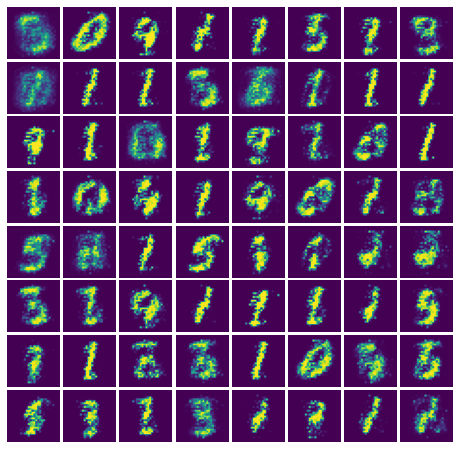

In [24]:
Image('generated_output/009.png')

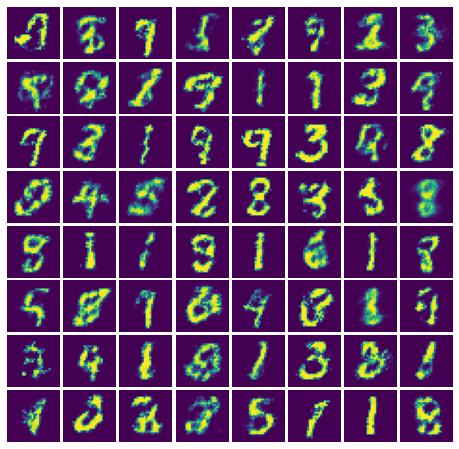

In [25]:
Image('generated_output/049.png')

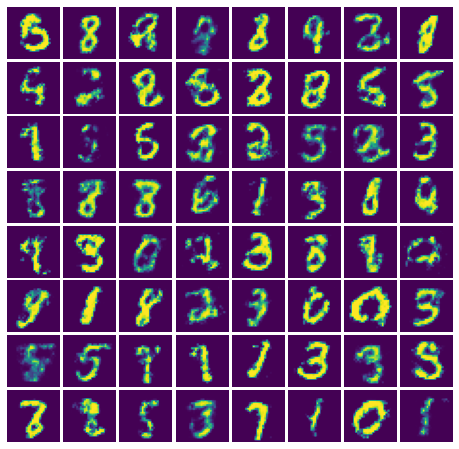

In [26]:
Image('generated_output/099.png')

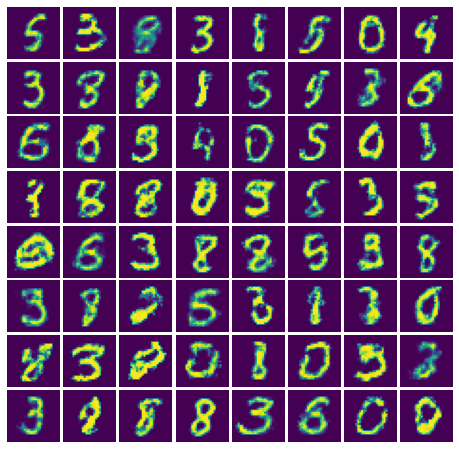

In [27]:
Image('generated_output/199.png')